# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


In [2]:
%matplotlib notebook

In [3]:
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Make a directory for saving results

In [4]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [5]:
uid = 'd851b9' #(scan num: 10871) (Measurement: visibility CoralPor lag time320us #1/1 )

#uid = 'a87398be' #count : 1 ['a87398'] (scan num: 4162) (Measurement: 0.5um Si in PEG 750Hz 1k mbs: .1x.4 )

uid = '641f9d'

In [6]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/


# Don't Change these lines below here

* get metadata

In [7]:
md = get_meta_data( uid )

* get data

In [8]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2016/12/02/32b06c0b-351d-46c8-ac92_2912_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [9]:
print_dict( md,  ['suid', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time', 
         'det_distanc','number of images', 'beam_center_x', 'beam_center_y', ] )

suid--> 641f9d
uid--> 641f9d68-ddb6-4357-a45a-2851cbfcc713
scan_id--> 10888
start_time--> 2016-12-02 15:07:15
stop_time--> 2016-12-02 15:11:30
sample--> CoralPor
Measurement--> Coralpor 50um periodic move 1.3ms @2Hz 500
acquire period--> 0.5
exposure time--> 0.00134
det_distanc--> 4.89
number of images--> 500
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata if Wrong Input

In [10]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
exposuretime= md['count_time']     #exposure time in sec
acquisition_period = md['frame_time']   #acquisition time in sec
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image

#center = [ 2070-1381-0, 1475-4] 

In [11]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

In [12]:
print_dict( setup_pargs )

timeperframe--> 0.5
center--> [816, 1443]
exposuretime--> 0.00134
lambda_--> 1.28481
dpix--> 0.0750000035623
Ldet--> 4889.99986649
path--> /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/
uid--> 641f9d


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [13]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy'


<IPython.core.display.Javascript object>


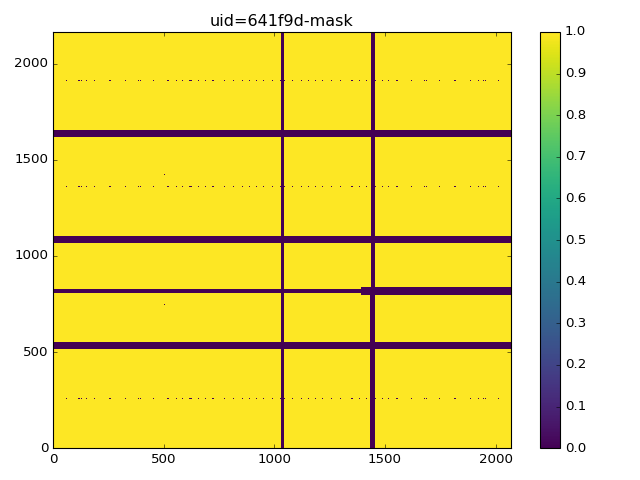

In [14]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = 'uid=%s-mask'%uid, reverse=True ) 
mask *= pixel_mask
show_img(mask,image_name = 'uid=%s-mask'%uid, save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [15]:
n=10
avg_img =  imgsa[n] #get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


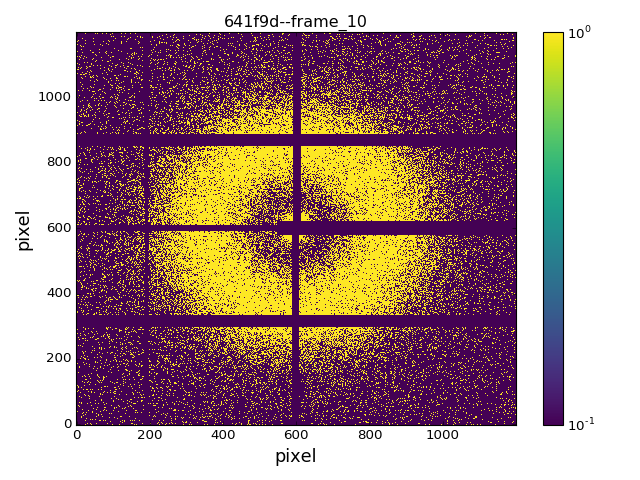

In [16]:
show_saxs_qmap( avg_img, setup_pargs, width=600, show_pixel = True,
               vmin=.1, vmax=1, logs=True, image_name= uid + '--frame_%s'%n )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [17]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.1115821646168148.
Will Always DO apply compress process.


In [18]:
good_start = 5  #make the good_start at least 0

Get each frame intensity:   6%|▋         | 32/500 [00:00<00:01, 317.83it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_641f9d68-ddb6-4357-a45a-2851cbfcc713.cmp.


Averaging 498 images:   2%|▏         | 8/500 [00:00<00:06, 73.67it/s]

No bad frames are involved.


Averaging 498 images: 100%|██████████| 500/500 [00:05<00:00, 89.76it/s] 


The good_start frame number is: 5 


<IPython.core.display.Javascript object>


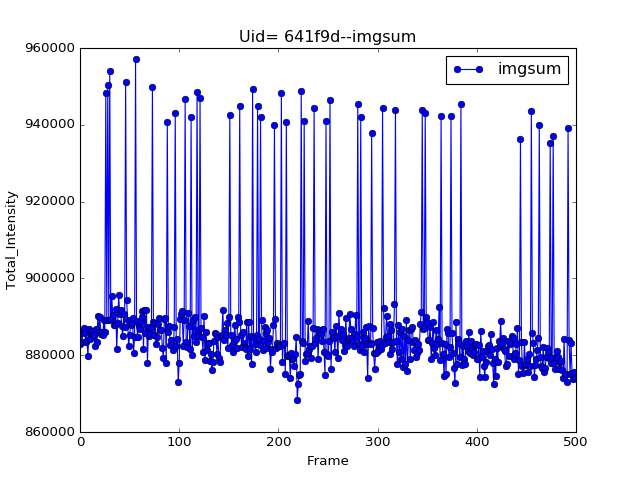

Total time: 0.12 min


In [19]:
t0= time.time()
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= False, bad_pixel_threshold= 1e14, bins=1, num_sub= 100  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs))
#FD = Multifile(filename, 0, len(imgs))
plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
       title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
run_time(t0)

## Get bad frame list by a polynominal fit

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


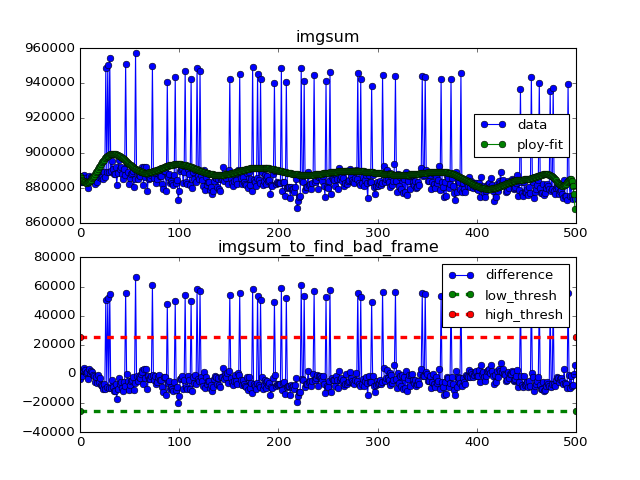

The bad frame list are [ 26  28  30  46  56  73  88  96 106 112 118 121 151 161 174 179 182 196
 203 208 223 226 236 248 252 280 283 294 305 318 345 348 364 374 384 444
 455 463 474 477 492]


In [20]:
bad_frame_list = get_bad_frame_list( imgsum, fit=True, plot=True, polyfit_order = 30, scale= 1.5)
print( 'The bad frame list are %s'%bad_frame_list)

#### For beamline to find the bad pixels

In [21]:
bp = find_bad_pixels( FD, bad_frame_list, md['uid'] )

In [22]:
bp.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

### Creat new mask by masking the bad pixels and get new avg_img

In [23]:
mask = mask_exclude_badpixel( bp, mask, md['uid'])
avg_img = get_avg_imgc( FD,  sampling = 1, bad_frame_list=bad_frame_list ) 

Averaging 462 images: 100%|██████████| 495/495 [00:05<00:00, 96.07it/s]


In [24]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename='uid=%s-imgsum'%uid, path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


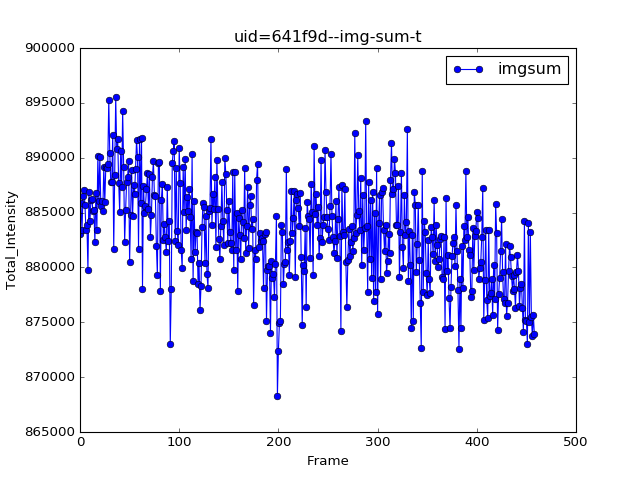

In [25]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

### Plot intensity average image

<IPython.core.display.Javascript object>


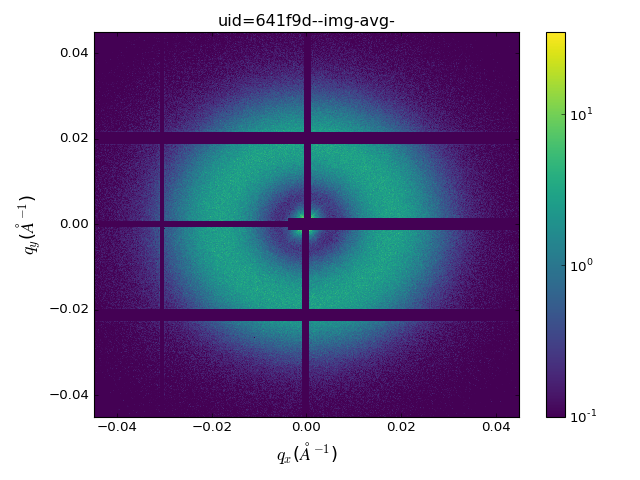

In [26]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= 'uid=%s--img-avg-'%uid,  save=True) 

## Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


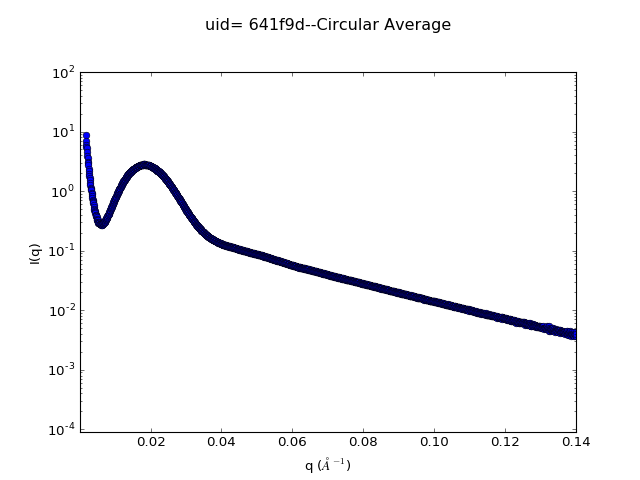

In [27]:
hmask = create_hot_pixel_mask( avg_img, threshold = 1, center=center, center_radius= 400)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e2], save=True)

In [28]:
pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
pd.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

In [29]:
mask =np.array( mask * hmask, dtype=bool) 
#show_img( mask )

# Fit Form Facotr

In [30]:
fit_form = False

In [31]:
if fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [32]:
uniform = True #False

### Define a non-uniform distributed rings by giving edges

In [33]:
if not uniform:    
    width = 0.0002    
    number_rings= 1    
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [34]:
if uniform:    
    inner_radius= 0.006  #16
    outer_radius = 0.05  #112    
    num_rings = 12
    width =    ( outer_radius - inner_radius)/(num_rings + 6)
    edges = None

In [35]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



<IPython.core.display.Javascript object>


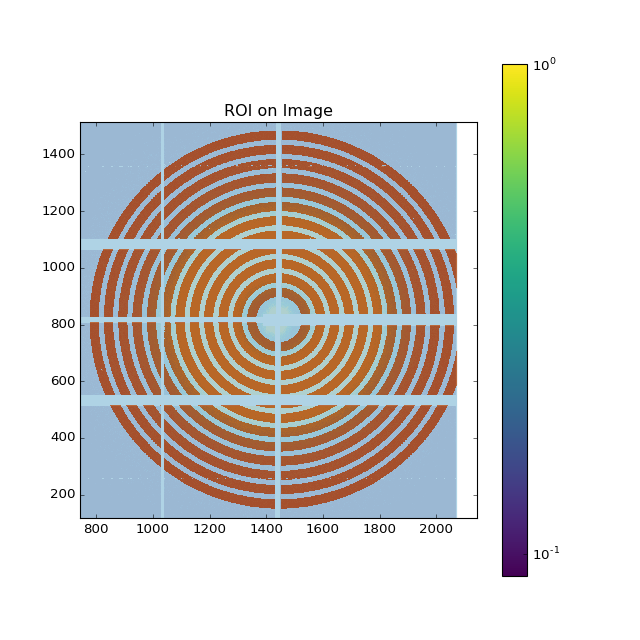

In [36]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,
                 save=True, path=data_dir, uid=uid, vmin=.09, vmax=1)

<IPython.core.display.Javascript object>


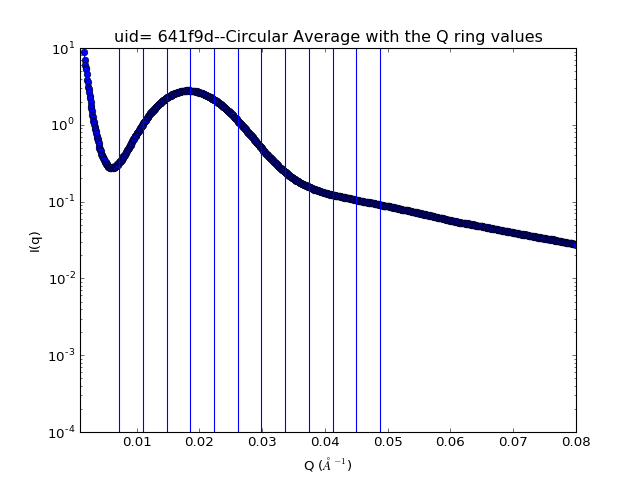

In [37]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.08],
                  ylim = [1e-4, 1e1],        save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


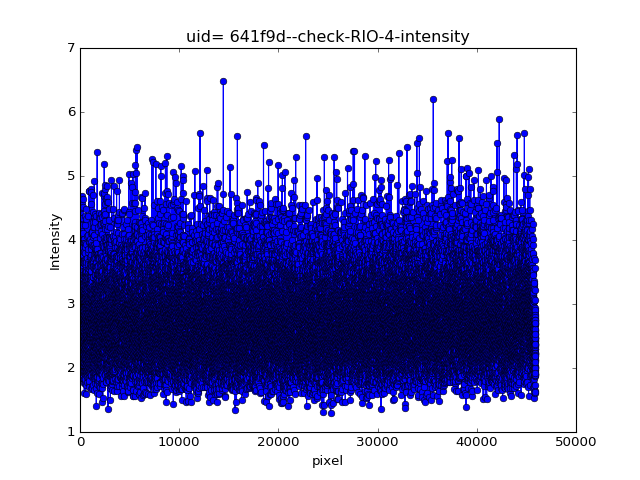

In [38]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 4, uid =uid, save=True, path=data_dir )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [39]:
Nimg = FD.end - FD.beg 
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 5, edges = None )
time_edge =  np.array( time_edge ) + good_start
print( time_edge )

[[  5  10]
 [250 255]
 [495 500]]


In [40]:
qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )

Averaging 993 images: 100%|██████████| 5/5 [00:00<00:00, 129.37it/s]


<IPython.core.display.Javascript object>


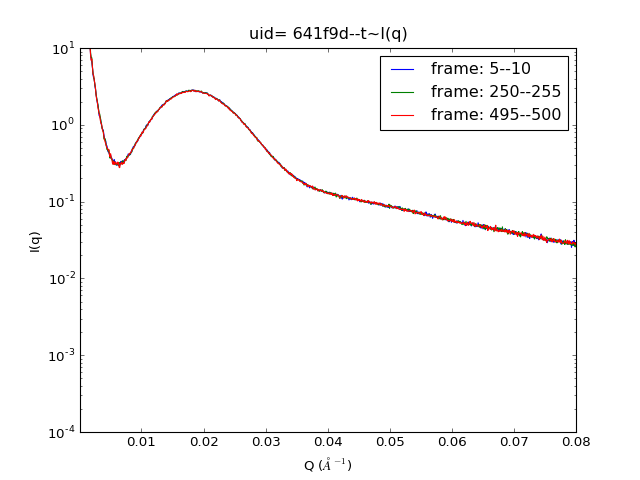

In [41]:
plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[0.0001,.08],
           ylim = [0.0001, 10], save=True )

## Do a waterfall analysis

In [42]:
if False:
    qindex = 3 
    wat = cal_waterfallc( FD, ring_mask, qindex= qindex, save =True, path=data_dir, uid=uid)

In [43]:
if False:
    plot_waterfallc( wat, qindex, aspect=None, 
                        vmax= 10, uid=uid, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 495/495 [00:03<00:00, 130.49it/s]


<IPython.core.display.Javascript object>


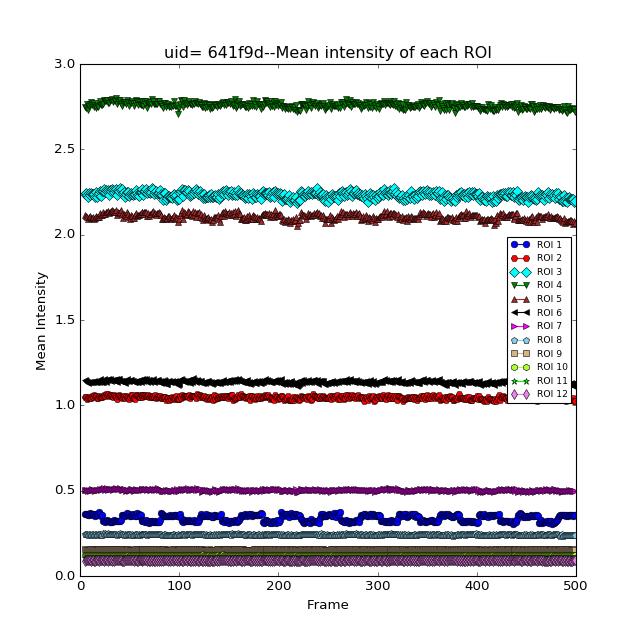

In [44]:
if True:
    times, mean_int_sets = cal_each_ring_mean_intensityc(FD, ring_mask, timeperframe = None,  )    
    plot_each_ring_mean_intensityc( times, mean_int_sets,  uid = uid, save=True, path=data_dir )
    ring_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [45]:
define_good_series = False
if define_good_series:
    FD = Multifile(filename, good_start, good_end = Nimg)

In [46]:
uid_ = uid + '--fra-%s-%s'%(FD.beg, FD.end)
print( uid_ )

641f9d--fra-5-500


In [47]:
lag_steps = None

In [48]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)

In [49]:
t0 = time.time()
g2, lag_steps  = cal_g2p( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                        imgsum= None, norm=norm )

run_time(t0)

In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
454 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

G2 calculation DONE!
Total time: 0.27 min


In [50]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid_  ) 

In [51]:
save_g2( g2, taus=taus, qr= q_ring_center, qz=None, uid=uid_, path= data_dir )

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/ with filename as uid=641f9d--fra-5-500--g2.csv


### Plot the one time correlation functions

In [52]:
fit= True

In [53]:
if not fit:
    plot_g2( g2, res_pargs= res_pargs,  master_plot='qz',vlim=[0.95, 1.05], geometry='saxs', append_name=  ''  )    

# Fit g2

In [54]:
if fit:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2,  res_pargs=res_pargs, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fit = dict(taus=taus_fit, q_ring_center= q_ring_center,  
                         path=data_dir, uid=uid +'_fra-%s-%s'%(FD.beg, FD.end) +'_g2_fit'       )
    

In [55]:
if fit:
    dfv = save_g2_fit_para_tocsv(g2_fit_result, 
                    filename= uid_  +'_g2_fit_paras', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/641f9d--fra-5-500_g2_fit_paras.csv


<IPython.core.display.Javascript object>


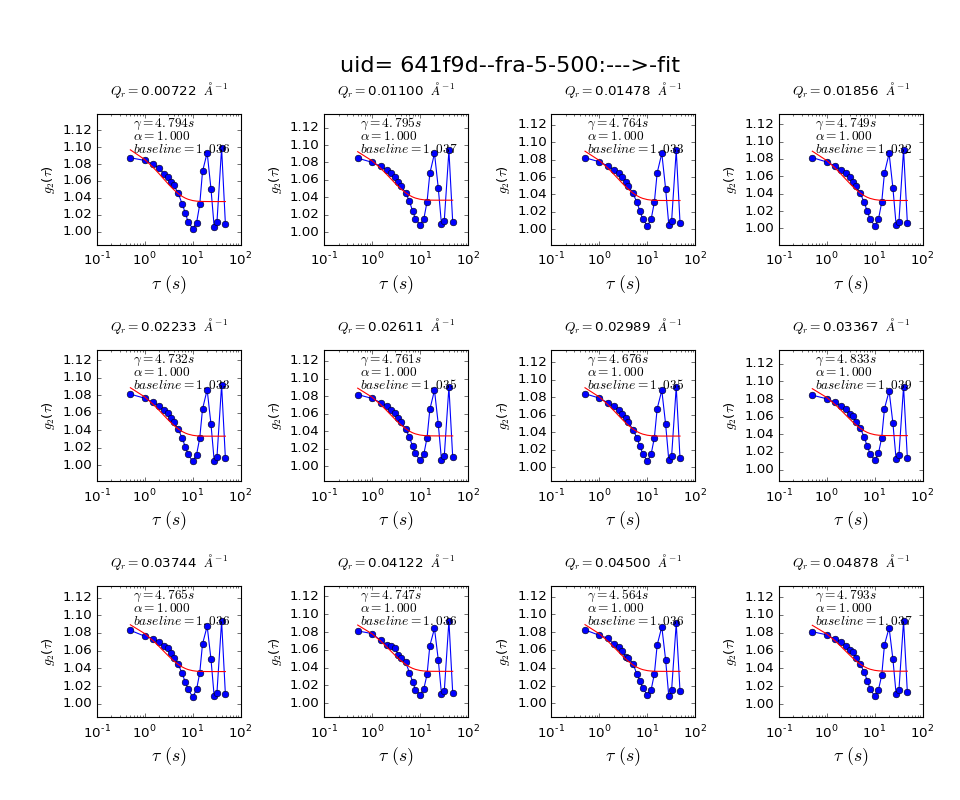

In [56]:
if fit:
    plot_g2( g2, res_pargs= res_pargs, tau_2 = taus_fit, g2_2 = g2_fit,  
        fit_res= g2_fit_result, function = 'stretched', master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name=  '-fit'  )

The fitted diffusion coefficient D0 is:  1.376e+02   A^2S-1


<IPython.core.display.Javascript object>


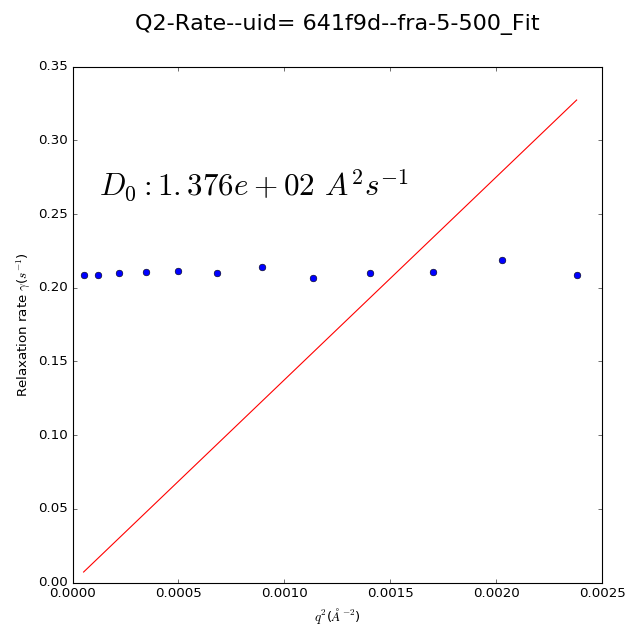

In [57]:
if fit:
    fit_q_rate(  q_ring_center[:],dfv['relaxation_rate'], power_variable= False, 
           uid=uid_  , path= data_dir )

# For two-time

In [58]:
run_two_time = True

In [59]:
if run_two_time:
    #norm = None
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()

100%|██████████| 495/495 [00:12<00:00, 40.49it/s]


In [60]:
t0=time.time()
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )
if lag_steps is None:
    num_bufs=8
    noframes = FD.end - FD.beg
    num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
    tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
    max_taus= lag_steps.max()

run_time( t0 )        

100%|██████████| 12/12 [00:05<00:00,  1.46it/s]

Total time: 0.10 min


<IPython.core.display.Javascript object>


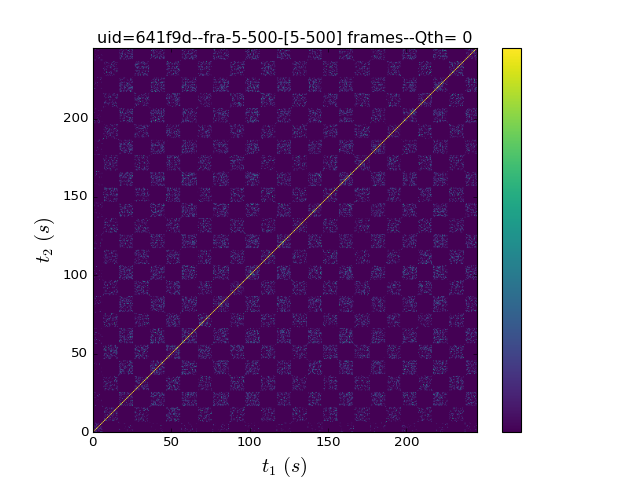

In [61]:
if run_two_time:
    show_C12(g12b, q_ind= 0, N1= FD.beg, N2=min( FD.end,1000), vmin=1.1, vmax=1.25,
             timeperframe=timeperframe,save=True,
             path= data_dir, uid = uid_ )
    

In [62]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargsb = dict(taus=tausb, q_ring_center=q_ring_center,  path=data_dir, uid=uid_       )
    save_g2( g2b, taus=tausb, qr= q_ring_center, qz=None, uid=uid_ +'-fromTwotime', path= data_dir )
    #plot_saxs_g2( g2b, tausb,  vlim=[0.95, 1.05], res_pargs=res_pargsb) 

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/ with filename as uid=641f9d--fra-5-500-fromTwotime--g2.csv


In [63]:
if run_two_time:
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit( g2b,  res_pargs=res_pargsb, 
                function = 'stretched',  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,})  
    
    res_pargs_fitb = dict(taus=taus_fitb, q_ring_center= q_ring_center,  
                         path=data_dir, uid=uid_  +'_g2b_fit'       )
    
    dfvb = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= uid_  + '_g2b_fit_paras', path=data_dir )

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/641f9d--fra-5-500_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


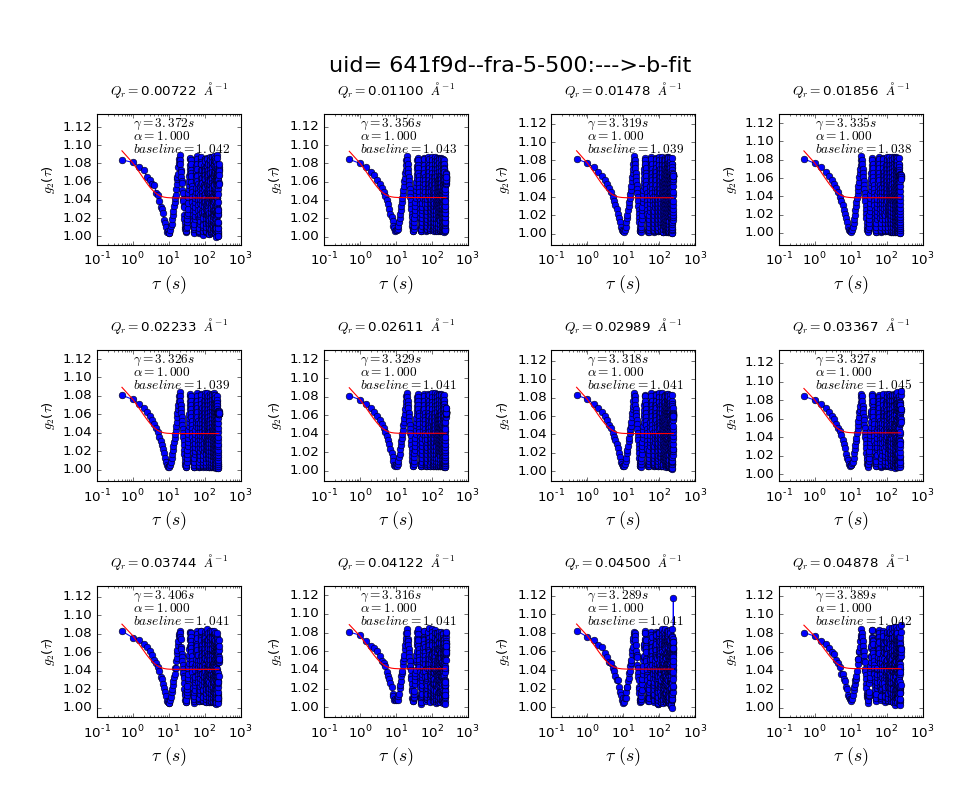

In [64]:
if run_two_time:
    plot_g2( g2b, res_pargs= res_pargsb, tau_2 = taus_fitb, g2_2 = g2_fitb,  
        fit_res= g2_fit_resultb, function = 'stretched', master_plot='qz',    
       vlim=[0.95, 1.05], geometry='saxs', append_name= '-b-fit'  )

<IPython.core.display.Javascript object>


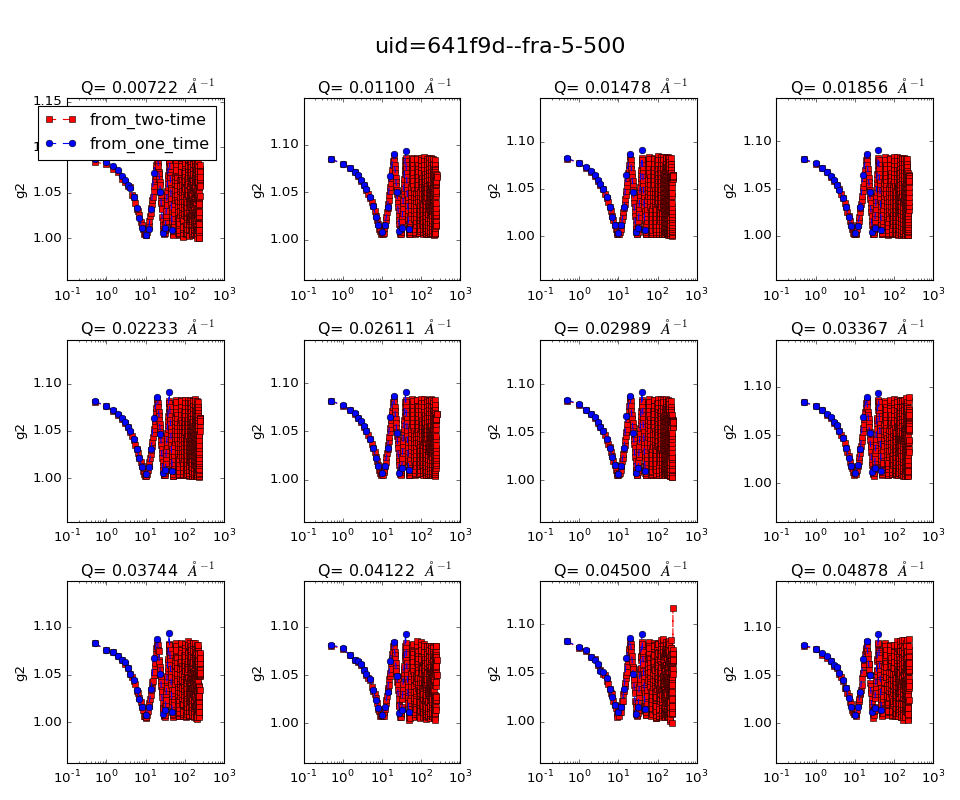

In [65]:
if run_two_time:
    #fit_q_rate(  q_ring_center[:],dfvb['relaxation_rate'], power_variable= False,  uid=uid +'-g2b' , path= data_dir )
    plot_saxs_two_g2( g2, taus, 
                 g2b, tausb, res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid_  )

# Four Time Correlation

In [66]:
run_four_time = True #False

In [67]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

Total time: 0.00 min


In [68]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir, uid=uid_      )
     
    save_saxs_g2(   g4,  res_pargs4, taus=taus4, filename= uid_  + '_g4.csv' )
              


The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/641f9d/ with filename as 641f9d--fra-5-500_g4.csv


<IPython.core.display.Javascript object>


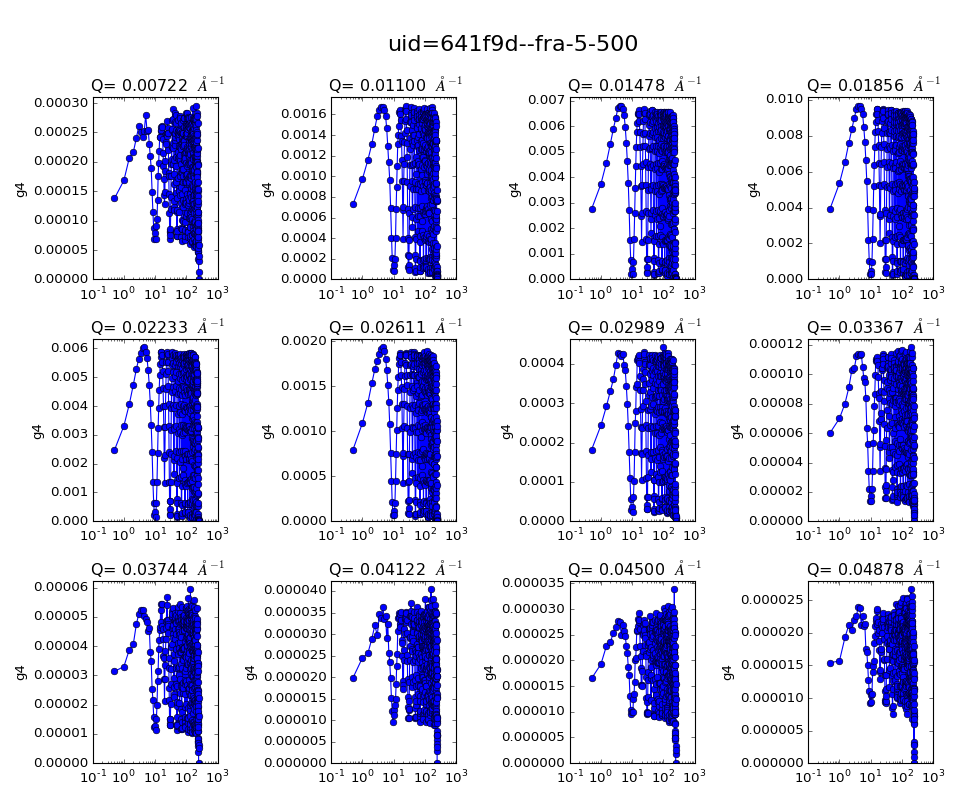

In [69]:
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4)  

In [70]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['beg'] = FD.beg
md['end'] = FD.end
psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'md.csv', 'w')

# Creat PDF Report

In [71]:
create_report = True


In [72]:
uid

'641f9d'

In [73]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
ver='_2'
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,ver)

In [80]:
if create_report:    
    c= create_pdf_report(  data_dir, uid, pdf_out_dir, filename= pdf_filename)    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=550, iq_fit =fit_form )
    c.report_ROI( top= 300)
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)
    #Page Three: two-time/two g2
    
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )      
        
    if run_four_time:
        c.new_page()
        c.report_header(page=4)
        c.report_four_time(  top= 720 ) 
        
    c.save_page()
    c.done()        

    


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_Analysis_Report_for_uid=641f9d_2.pdf
****************************************


## Attach the PDF report to Olog 

In [75]:
c.filename

'/XF11ID/analysis/2016_3/yuzhang/Results/XPCS_Analysis_Report_for_uid=641f9d_2.pdf'

In [76]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [77]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 
try:
    update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
except:
    print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%c.filename)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Analysis PDF Report and with the attachments


# The End!